In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

2023-06-22 17:08:45.464050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Data into tf Pipline

In [128]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [181]:
face1= tf.data.Dataset.list_files('/home/zok/joker/scratch/deepfake_model/data/biden/*.jpg', shuffle=False)
face1 = face1.map(load_image)
face1 = face1.map(lambda x: tf.image.resize(x, (120,120)))
face1 = face1.map(lambda x: x/255)

2023-06-22 16:54:04.955257: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 16:54:04.969914: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 16:54:04.981261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [182]:
image_generator = face1.batch(4).as_numpy_iterator()

2023-06-22 16:54:05.379730: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 16:54:05.384498: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 16:54:05.388651: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [183]:
plot_images = image_generator.next()

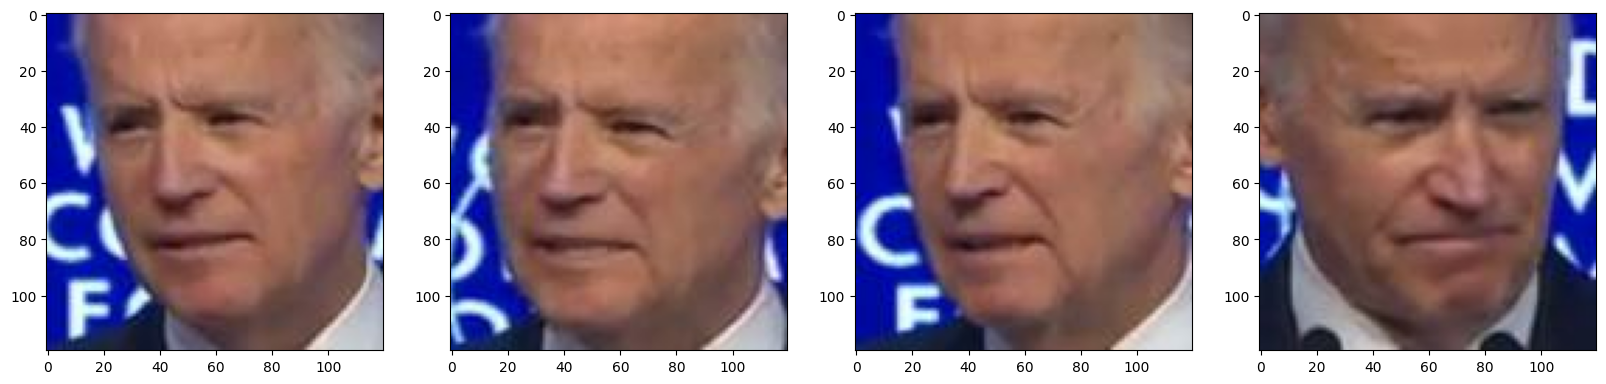

In [184]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

### Spilt Data

In [185]:
train_size_1 = int(len(face1)*.7)
val_size_1 = int(len(face1)*.2)
test_size_1 = int(len(face1)*.1)

In [186]:
train_1 = face1.take(train_size_1)
val_1 = face1.skip(train_size_1).take(val_size_1)
test_1 = face1.skip(train_size_1+val_size_1).take(test_size_1)

In [187]:
train_1

<TakeDataset element_spec=TensorSpec(shape=(120, 120, None), dtype=tf.float32, name=None)>

In [2]:
def create_dataset(path):
    images = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            image = cv2.imread(os.path.join(dirname, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype('float32')
            image /= 255.0
            images.append(image)
    images = np.array(images)
    return images

In [3]:
faces_1 = create_dataset('scratch/deepfake_model/data/biden/')
faces_2 = create_dataset('scratch/deepfake_model/data/trump/')

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(faces_1, faces_1, test_size=0.20, random_state=0)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(faces_2, faces_2, test_size=0.15, random_state=0)

In [6]:
from keras import layers
import keras
from tensorflow.keras.callbacks import ModelCheckpoint

### Encoder

In [7]:
input_img = layers.Input(shape=(120, 120, 3))
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(1024,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(9216)(x)
encoded = layers.Reshape((3,3,1024))(x)
encoder = keras.Model(input_img, encoded,name="encoder")

2023-06-22 17:09:08.850335: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 17:09:09.771094: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 17:09:09.771193: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-22 17:09:09.771223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1990] Ignoring visible gpu device (device: 0, name: Radeon RX 560 Series, pci bus id: 0000:01:00.0) with AMDGPU version : gfx803. The supported AMDGPU versions are gfx1030, gfx900, gfx906, gfx908, gfx90a.
2023-06-22 17:09:

### Decoder

In [8]:
decoder_input= layers.Input(shape=((3,3,1024)))
x = layers.Conv2D(1024,kernel_size=5, strides=2, padding='same',activation='relu')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(np.prod((120, 120, 3)))(x)
decoded = layers.Reshape((120, 120, 3))(x)
decoder = keras.Model(decoder_input, decoded,name="decoder")

2023-06-22 17:09:10.832265: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 104857600 exceeds 10% of free system memory.
2023-06-22 17:09:10.890815: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 104857600 exceeds 10% of free system memory.
2023-06-22 17:09:10.962991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:10.965419: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:11.056735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:11.058106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:11.100305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:11.101387: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:11.801075: I tensorflow/core/common_runtime/gpu_f

In [9]:
auto_input = layers.Input(shape=(120,120,3))
encoded = encoder(auto_input)
decoded = decoder(encoded)
 
autoencoder = keras.Model(auto_input, decoded,name="autoencoder")
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5, beta_2=0.999), loss='mae')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 encoder (Functional)        (None, 3, 3, 1024)        54162944  
                                                                 
 decoder (Functional)        (None, 120, 120, 3)       86880192  
                                                                 
Total params: 141,043,136
Trainable params: 141,043,136
Non-trainable params: 0
_________________________________________________________________


2023-06-22 17:09:12.773139: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:12.775471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [10]:
checkpoint1 = ModelCheckpoint("/kaggle/working/autoencoder_a.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', save_freq=1)
history1 = autoencoder.fit(X_train_a, X_train_a, epochs=10, batch_size=512, shuffle=True, validation_data=(X_test_a, X_test_a), callbacks=[checkpoint1])

2023-06-22 17:09:16.535145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:16.557802: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:17.103848: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:17.141549: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:17.260057: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:17.274305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:17.280702: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:17.295606: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:17.375686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:17

Epoch 1/10


2023-06-22 17:09:17.754597: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:17.804964: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:17.829519: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-22 17:09:19.387277: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
